In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/clean/clean_housing_tunisia_model_ready.csv")

df.head()


,price,surface,rooms,governorate,property_type,log_price,log_surface
0,310000.0,150.0,3,Monastir,Appart,12.644331,5.017280
1,621626.0,150.0,3,Sousse,Appart,13.340096,5.017280
2,605561.0,148.0,3,Sousse,Appart,13.313912,5.003946
3,620152.0,132.0,2,Sousse,Appart,13.337722,4.890349
4,2700000.0,476.0,6,Ariana,House,14.808763,6.167516


### Define Target and features

In [6]:
df["log_price"] = np.log1p(df["price"])

X = df[["surface", "rooms", "governorate", "property_type"]]
y = df["log_price"]


### Encode Categorical Values

In [7]:
X = pd.get_dummies(
    X,
    columns=["governorate", "property_type"],
    drop_first=True
)


### Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R²:", r2)


Linear Regression RMSE: 0.5529072592130946
Linear Regression R²: 0.5168401652152878


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)


Random Forest RMSE: 0.5119735817415092
Random Forest R²: 0.5857320421308261


### Model Comparison

In [11]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse, rmse_rf],
    "R2": [r2, r2_rf]
})

results


,Model,RMSE,R2
0,Linear Regression,0.552907,0.516840
1,Random Forest,0.511974,0.585732


#### Random forest hyperparameter tuning

In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'n_jobs': [-1]
}

# Instantiate Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best score (RMSE)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1; total time=   2.6s
[CV] END max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, n_estimators=200, n_jobs=-1; total time=   3.9s
[CV] END max_depth=10, min_samples_leaf=1, n_estimators=200, n_jobs=-1; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=2, n_estimators=100, n_jobs=-1; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, n_estimators=200, n_jobs=-1; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=2, n_estimators=100, n_jobs=-1; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=2, n_estimators=100, n_jobs=-1; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=2, n_estimators=200, n_jobs=-1; total time=   2.7s
[CV] END max_depth=10, min_s

### Changing random forest hyperparameters


In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    min_samples_leaf=4,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)

Random Forest RMSE: 0.4818840858129119
Random Forest R²: 0.6329954840137784


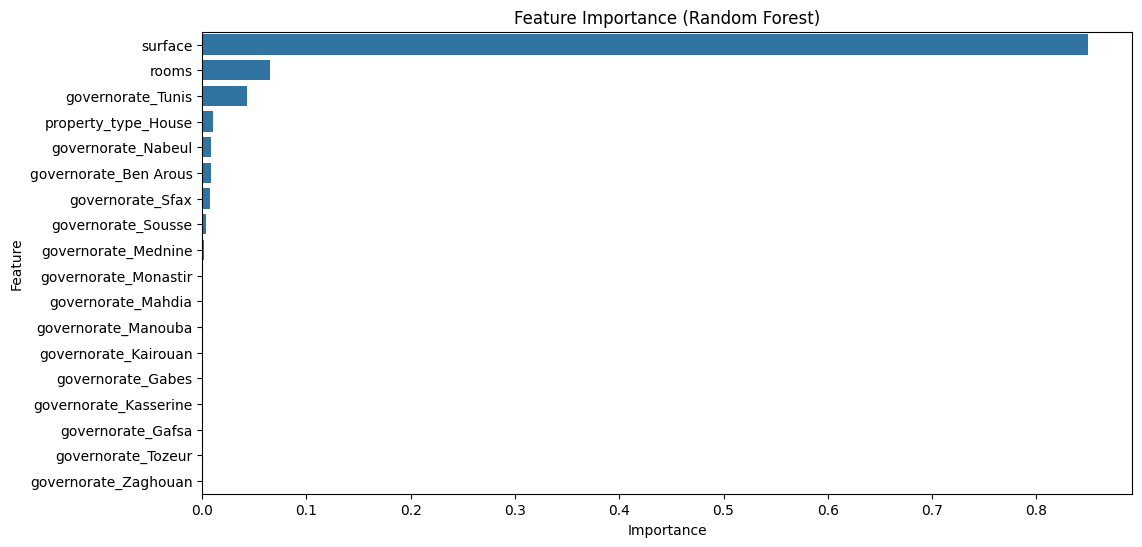

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_

# Create a DataFrame for easy plotting
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feat_importance)
plt.title("Feature Importance (Random Forest)")
plt.show()


## XGBoost

In [15]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,          
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)


XGBoost RMSE: 0.4800111744178443
XGBoost R²: 0.6358427710908419
